```{index} single: application; inventory management
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} sample average approximation
```
```{index} stochastic optimization
```
```{index} simulations
```

# Stock optimization for seafood distribution center

In [10]:
# install dependencies and select solver
%pip install -q amplpy pandas matplotlib numpy scipy

SOLVER = "cbc"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

## Problem description
Each day a seafood distribution center buys $x$ tons of tuna at the unit cost $c$ per ton. The next day a demand $z$ is observed from the retailers to whom the fish is sold at a unit price $p > c$. Any leftover tuna needs to be stored in a cold warehouse at a unit holding cost $h$. The seafood distribution center cannot sell more fish than it has in stock, thus at most $\min\{z, x \}$ tons will be sold which will leave $h(x-z)^+$ tons leftover, where $(\cdot)^+$ is the positive residual (that is $a^+:=\max\{0,a\}$). Accounting for these costs, the net profit is $p \min\{z, x \} - cx - h (x-z)^+.$

Given a reasonable estimate of the probability distribution $\mathbb P$ of the tuna demand $z$, to maximize the long-term net profit then we can formulate the following optimization problem:

$$
\begin{align*}
    \max \quad & \mathbb{E}  [ p \min\{z, x \} - cx - h (x-z)^+ ]\\
    \text{s.t.} \quad & x \geq 0.
\end{align*}
$$

Since we have $x \geq 0$ regardless of the demand $z$, the feasible set for the decision variable $x$ is not affected by unknown demand.

## Explicit analytical solution

Assume further that the demand for tuna in tons can be modeled as a continuous random variable $z$ with cumulative distribution function $F(\cdot)$. We consider the following three distributions:

1. A [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution#Cumulative_distribution_function) on the interval $[25, 175]$;

2. A [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution#Cumulative_distribution_function) on the interval $[50,+\infty)$ with $x_m=50$ and exponent $\alpha=2$. Recall that the inverse CDF for a Pareto distribution is given by* $F^{-1}(\varepsilon) = \frac{x_m}{(1-\varepsilon)^{1/\alpha}}$;

3. A [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution#Cumulative_distribution_function) on the interval $[0,+\infty)$ with shape parameter $k=2$ and scale parameter $\lambda=113$.

Note that all the three distributions above have the same expected value, that is $\mathbb E z = 100$ tons. 

The optimal solution of the seafood inventory problem using the closed-form formula that features the inverse CDFs/quantile functions $F^{-1}$ of the considered distribution, that is

$$
x^* = F^{-1} \left( \frac{p-c}{p+h}\right).
$$

In the example below, we report the numerical solution corresponding to the parameters $c = 10$, $p = 25$, and $h = 3$, which determine the quantile of interest, that is $q=\frac{p-c}{p+h} \approx 0.5357$. 

Mean of Uniform distribution = 100.00
Mean of Pareto distribution = 100.00
Mean of Weibull distribution = 100.00


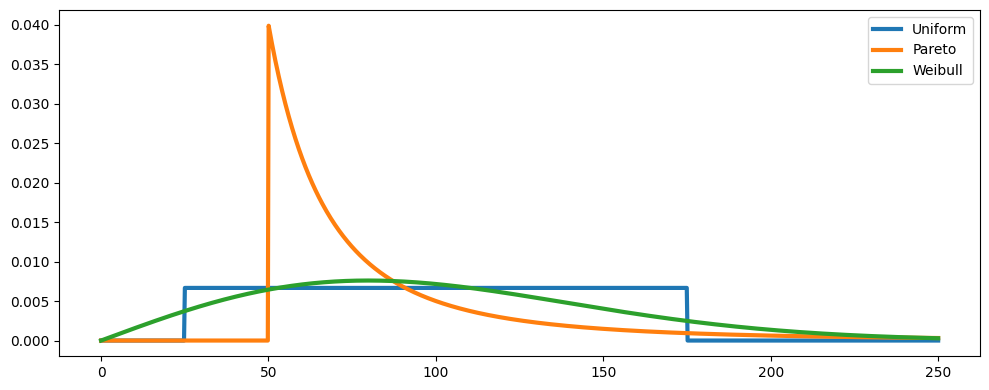

The quantile of interest given the parameters is equal to q = 0.5357.

The optimal solution for Uniform distribution is: 105.36 tons
The optimal solution for Pareto distribution is: 73.38 tons
The optimal solution for Weibull distribution is: 98.84 tons


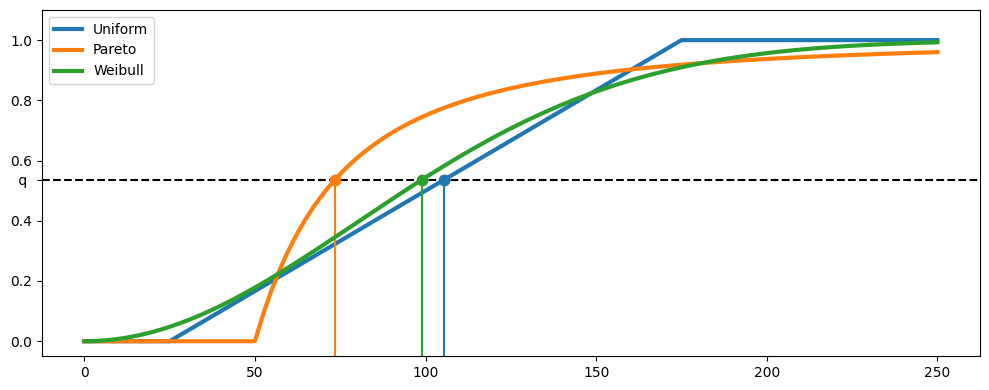

In [12]:
# Setting parameters
c = 10
p = 25
h = 3

distributions = {
    "Uniform": stats.uniform(loc=25, scale=150),
    "Pareto": stats.pareto(scale=50, b=2),
    "Weibull": stats.weibull_min(scale=112.838, c=2),
}

for name, distribution in distributions.items():
    print(f"Mean of {name} distribution = {distribution.mean():0.2f}")

# show PDFs
x = np.linspace(0, 250, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
lines = []
for name, distribution in distributions.items():
    ax.plot(x, distribution.pdf(x), lw=3, label=name)
ax.legend()
fig.tight_layout()
plt.show()

# quantile
q = (p - c) / (p + h)

# show CDFs and graphical solutions
extraticks = [q]
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axhline(q, linestyle="--", color="k")
for name, distribution in distributions.items():
    x_opt = distribution.ppf(q)
    (line,) = ax.plot(x, distribution.cdf(x), lw=3, label=name)
    c = line.get_color()
    ax.plot([x_opt] * 2, [-0.05, q], color=c)
    ax.plot(x_opt, q, ".", color=c, ms=15)
plt.yticks(list(plt.yticks()[0]) + [q], list(plt.yticks()[1]) + [" q "])
plt.ylim(-0.05, 1.1)
ax.legend()
fig.tight_layout()

print(f"The quantile of interest given the parameters is equal to q = {q:.4f}.\n")

for name, distribution in distributions.items():
    x_opt = distribution.ppf(q)
    print(f"The optimal solution for {name} distribution is: {x_opt:0.2f} tons")

## Deterministic solution for average demand

We now find the optimal solution of the *deterministic LP model* obtained by assuming the demand is constant and equal to the average demand, i.e., $z = \bar{z} = \mathbb E z = 100$.

In [13]:
%%writefile seafood.mod

param c;
param p;
param h;

# key parameter for possible parametric study
param mean_demand;

# first stage variables
var x >= 0;

var first_stage_profit = -c * x;

# second stage variables and constraints
var y >= 0;
var z >= 0;

s.t. cant_sell_fish_i_dont_have: y <= mean_demand;
s.t. fish_do_not_disappear: y + z == x;

var second_stage_profit = p * y - h * z;
    
# objective
maximize total_profit: first_stage_profit + second_stage_profit;

Overwriting seafood.mod


In [14]:
# problem data
c = 10
p = 25
h = 3
mean_demand = 100

# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("seafood.mod")

# Load the data
ampl.param["c"] = c
ampl.param["p"] = p
ampl.param["h"] = h
ampl.param["mean_demand"] = mean_demand

ampl.option["solver"] = SOLVER
ampl.solve()

print("solve_result", ampl.get_value("solve_result"))
print("solve_message", ampl.get_value("solve_message"))

assert ampl.get_value("solve_result") == "solved"

print(
    f"Optimal solution for determistic demand equal to the average demand = {ampl.var['x'].value():.1f} tons"
)
print(f"Optimal deterministic profit = {ampl.obj['total_profit'].value():.0f}€")

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 1500
0 simplex iterations
solve_result solved
solve_message cbc 2.10.7: optimal solution; objective 1500
0 simplex iterations

Optimal solution for determistic demand equal to the average demand = 100.0 tons
Optimal deterministic profit = 1500€


## Profits resulting from using average demand

We now assess how well we perform by taking the average demand as input for each of the three demand distributions above.

For a fixed decision variable $x=100$, approximate the expected net profit of the seafood distribution center for each of the three distributions above using the Sample Average Approximation method with $N=2500$ points. More specifically, generate $N=2500$ samples from the considered distribution and solve the extensive form of the stochastic LP resulting from those $N=2500$ scenarios.

In [15]:
%%writefile seafood.mod

param N; # number of samples

param c;
param p;
param h;

set indices := 1..N;
param xi{indices};

# first stage variable: x (amount of fish bought)
var x;

var first_stage_profit = -c * x;

# second stage variables: y (sold) and z (unsold)
var y{indices} >= 0;
var z{indices} >= 0;

# second stage constraints
s.t. cantsoldthingsfishdonthave {i in indices}: y[i] <= xi[i];
s.t. fishdonotdisappear {i in indices}: y[i] + z[i] == x;

var second_stage_profit = sum{i in indices}(p * y[i] - h * z[i]) / N;

# objective
maximize total_expected_profit: first_stage_profit + second_stage_profit;

Overwriting seafood.mod


In [16]:
# SAA of the two-stage stochastic LP to calculate the expected profit when buying the average


def NaiveSeafoodStockSAA(N, sample, distributiontype):
    ampl = AMPL()
    ampl.read("seafood.mod")

    # Load the data
    ampl.param["N"] = N
    ampl.param["xi"] = sample
    ampl.param["c"] = c
    ampl.param["p"] = p
    ampl.param["h"] = h

    ampl.var["x"].fix(100)

    ampl.option["solver"] = SOLVER
    ampl.solve()

    total_expected_profit = ampl.obj["total_expected_profit"].value()

    print(f"- {distributiontype}-distributed demand: {total_expected_profit:.2f}€")

    return total_expected_profit


np.random.seed(0)
N = 7500
print(
    f"Approximate expected optimal profit calculate with {N} samples when assuming the average demand with"
)

samples = np.random.uniform(low=25.0, high=175.0, size=N)
naiveprofit_uniform = NaiveSeafoodStockSAA(N, samples, "Uniform")

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) * xm
naiveprofit_pareto = NaiveSeafoodStockSAA(N, samples, "Pareto")

shape = 2
scale = 113
samples = scale * np.random.weibull(a=shape, size=N)
naiveprofit_weibull = NaiveSeafoodStockSAA(N, samples, "Weibull")

Approximate expected optimal profit calculate with 7500 samples when assuming the average demand with
cbc 2.10.7cbc 2.10.7: optimal solution; objective 966.3575226
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1112642266871644e-16;"
will change deduced dual values.

- Uniform-distributed demand: 966.36€
cbc 2.10.7cbc 2.10.7: optimal solution; objective 787.7127276
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.1115350615426187e-16;"
will change deduced dual values.

- Pareto-distributed demand: 787.71€
cbc 2.10.7cbc 2.10.7: optimal solution; objective 910.5460195
0 simplex iterations

"option abs_boundtol 2.220446049250313e-16;"
or "option rel_boundtol 1.1163012210250776e-16;"
will change deduced dual values.

- Weibull-distributed demand: 910.55€


## Approximating the solution using Sample Average Approximation method

We now approximate the optimal solution of stock optimization problem for each of the three distributions above using the Sample Average Approximation method. More specifically, generate $N=5000$ samples from each of the three distributions and thhen solve the extensive form of the stochastic LP resulting from those $N=5000$ scenarios. For each of the three distribution, we compare the optimal expected profit with that obtained before and calculate the value of the stochastic solution (VSS).

In [17]:
# Two-stage stochastic LP using SAA


def SeafoodStockSAA(N, sample, distributiontype, printflag=True):
    ampl = AMPL()
    ampl.read("seafood.mod")

    # Load the data
    ampl.param["N"] = int(N)
    ampl.param["xi"] = sample
    ampl.param["c"] = c
    ampl.param["p"] = p
    ampl.param["h"] = h

    ampl.option["solver"] = SOLVER
    ampl.solve()

    xval = ampl.var["x"].value()
    total_expected_profit = ampl.obj["total_expected_profit"].value()

    if printflag:
        print(
            f"Approximate solution in the case of {distributiontype} distribution using N={N:.0f} samples"
        )
        print(f"Approximate optimal solution: x = {xval:.2f} tons")
        print(f"Approximate expected optimal profit: {total_expected_profit:.2f}€")

    return total_expected_profit, xval


np.random.seed(1)
N = 5000

samples = np.random.uniform(low=25.0, high=175.0, size=N)
smartprofit_uniform, x = SeafoodStockSAA(N, samples, "uniform")
print(
    f"Value of the stochastic solution: {smartprofit_uniform:.2f}-{naiveprofit_uniform:.2f} = {smartprofit_uniform-naiveprofit_uniform:.2f}€\n"
)

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) * xm
smartprofit_pareto, x = SeafoodStockSAA(N, samples, "Pareto")
print(
    f"Value of the stochastic solution: {smartprofit_pareto:.2f}-{naiveprofit_pareto:.2f} = {smartprofit_pareto-naiveprofit_pareto:.2f}€\n"
)

shape = 2
scale = 113
samples = scale * np.random.weibull(a=shape, size=N)
smartprofit_weibull, x = SeafoodStockSAA(N, samples, "Weibull")
print(
    f"Value of the stochastic solution: {smartprofit_weibull:.2f}-{naiveprofit_weibull:.2f} = {smartprofit_weibull-naiveprofit_weibull:.2f}€\n"
)

cbc 2.10.7cbc 2.10.7: optimal solution; objective 979.9839901
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1110083861286932e-16;"
will change deduced dual values.

Approximate solution in the case of uniform distribution using N=5000 samples
Approximate optimal solution: x = 105.82 tons
Approximate expected optimal profit: 979.98€
Value of the stochastic solution: 979.98-966.36 = 13.63€

cbc 2.10.7cbc 2.10.7: optimal solution; objective 890.7155021
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.1143617169625138e-16;"
will change deduced dual values.

Approximate solution in the case of Pareto distribution using N=5000 samples
Approximate optimal solution: x = 73.33 tons
Approximate expected optimal profit: 890.72€
Value of the stochastic solution: 890.72-787.71 = 103.00€

cbc 2.10.7cbc 2.10.7: optimal solution; objective 919.0820282
0 simplex iterations

"option abs_boundtol 2.220446049250313e

## Convergence of the SAA method

The SAA method becomes more precise as the sample size $N$ increases. To illustrate this, we solve the same optimization problem as before but using a different number of samples, with the sample size $N$ increasing from $25$ to $2500$. As we can see, the approximate solutions converge to the theoretical ones as the sample size increases.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 1223.394075
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.3241321748445902e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 909.2270044
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.1373053653223878e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 797.3011827
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.6305659042742296e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 1074.612562
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.2771060631448903e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 856.6601206
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol


"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1210182486100853e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 887.4716169
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.157899302953856e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 911.2385061
0 simplex iterations

"option abs_boundtol 1.7763568394002505e-15;"
or "option rel_boundtol 1.1341070950773802e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 961.9583722
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1210182486100853e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 886.4808101
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.157899302953856e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: op

cbc 2.10.7cbc 2.10.7: optimal solution; objective 963.7911211
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1210182486100853e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 895.5210039
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.1214255995497563e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 930.1225391
0 simplex iterations

"option abs_boundtol 1.7763568394002505e-15;"
or "option rel_boundtol 1.1171050829491662e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 959.3001758
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1210182486100853e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 897.8422933
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundto

cbc 2.10.7cbc 2.10.7: optimal solution; objective 876.1005715
0 simplex iterations

"option abs_boundtol 8.881784197001252e-16;"
or "option rel_boundtol 1.110334144320895e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 966.7912306
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1118454917392254e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 898.1102367
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.1189326177402404e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 884.7896297
0 simplex iterations

"option abs_boundtol 8.881784197001252e-16;"
or "option rel_boundtol 1.110334144320895e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 962.3828639
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1

cbc 2.10.7cbc 2.10.7: optimal solution; objective 889.489955
0 simplex iterations

"option abs_boundtol 8.881784197001252e-16;"
or "option rel_boundtol 1.110334144320895e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 973.2173051
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1112642266871644e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 892.1398134
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.110280920477166e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 890.9530746
0 simplex iterations

"option abs_boundtol 8.881784197001252e-16;"
or "option rel_boundtol 1.110334144320895e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 973.7927795
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1

cbc 2.10.7cbc 2.10.7: optimal solution; objective 896.7451246
0 simplex iterations

"option abs_boundtol 4.440892098500626e-16;"
or "option rel_boundtol 1.114355745645983e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 974.0600828
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1112642266871644e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 888.3877703
0 simplex iterations

"option abs_boundtol 7.105427357601002e-15;"
or "option rel_boundtol 1.110280920477166e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 891.6830897
0 simplex iterations

"option abs_boundtol 4.440892098500626e-16;"
or "option rel_boundtol 1.114355745645983e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 976.596548
0 simplex iterations

"option abs_boundtol 3.552713678800501e-15;"
or "option rel_boundtol 1.1

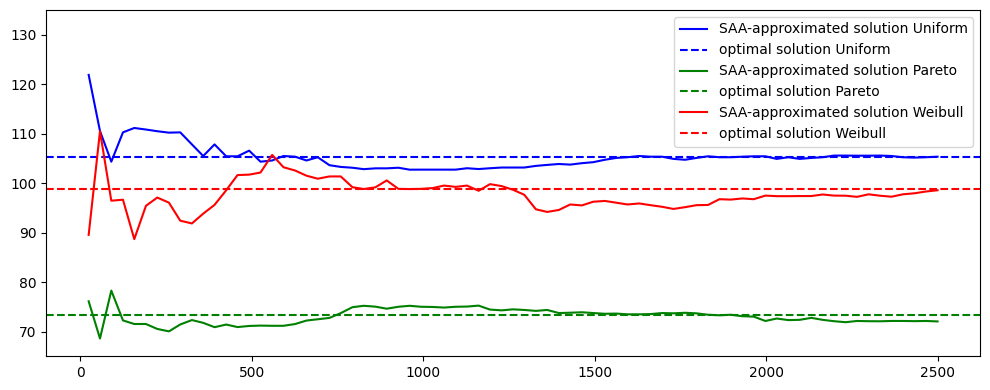

In [18]:
shape = 2
xm = 50
scale = 113
levels = 75

table = np.zeros((levels, 7))

for i, N in enumerate(np.linspace(25, 2500, levels, dtype=int)):
    np.random.seed(0)
    samples = np.random.uniform(low=25.0, high=175.0, size=N)
    profit_uniform, xu = SeafoodStockSAA(N, samples, "uniform", False)
    samples = (np.random.pareto(a=shape, size=N) + 1) * xm
    profit_pareto, xp = SeafoodStockSAA(N, samples, "Pareto", False)
    samples = scale * np.random.weibull(a=shape, size=N)
    profit_weibull, xw = SeafoodStockSAA(N, samples, "Weibull", False)
    table[i] = [N, xu, xp, xw, profit_uniform, profit_pareto, profit_weibull]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(table[:, 0], table[:, 1], "-b", label="SAA-approximated solution Uniform")
ax.axhline(y=105.36, color="b", linestyle="--", label="optimal solution Uniform")
ax.plot(table[:, 0], table[:, 2], "-g", label="SAA-approximated solution Pareto")
ax.axhline(y=73.38, color="g", linestyle="--", label="optimal solution Pareto")
ax.plot(table[:, 0], table[:, 3], "-r", label="SAA-approximated solution Weibull")
ax.axhline(y=98.84, color="r", linestyle="--", label="optimal solution Weibull")
ax.legend(loc="upper right")
plt.ylim(65, 135)
fig.tight_layout()